<a href="https://colab.research.google.com/github/LuisM6/hiddeneigenmice/blob/main/Luis_Stringer_Spontaneous_Analysis_PCA_And_CCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# import libraries 
import ipywidgets as widgets
#@title Data retrieval
import os, requests
fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"
if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


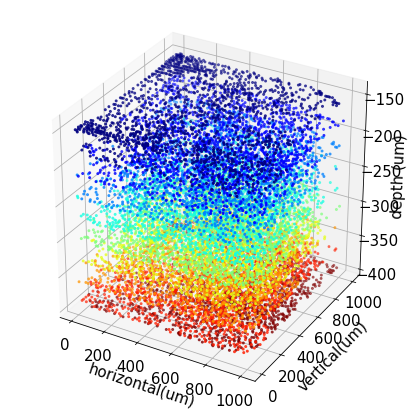

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');


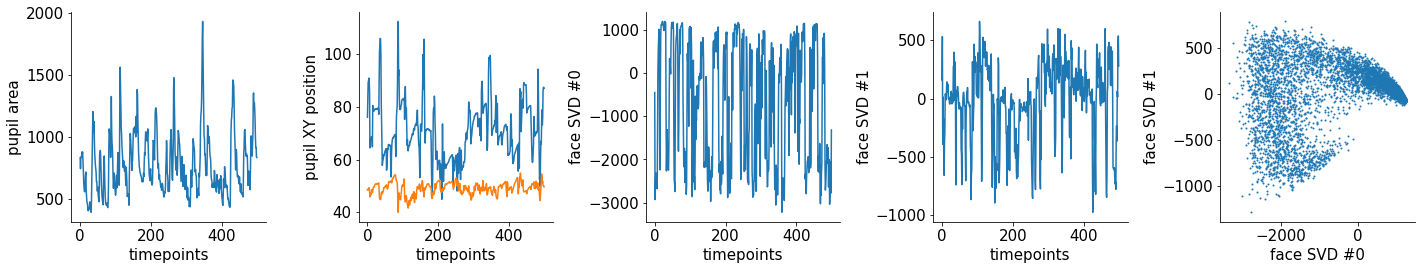

In [10]:
#@title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1,5,1)
plt.plot(dat['pupilArea'][:500,0])
ax.set(xlabel='timepoints', ylabel = 'pupil area')

ax = plt.subplot(1,5,2)
plt.plot(dat['pupilCOM'][:500,:])
ax.set(xlabel='timepoints', ylabel = 'pupil XY position')

ax = plt.subplot(1,5,3)
plt.plot(dat['beh_svd_time'][:500,0])
ax.set(xlabel='timepoints', ylabel = 'face SVD #0')

ax = plt.subplot(1,5,4)
plt.plot(dat['beh_svd_time'][:500,1])
ax.set(xlabel='timepoints', ylabel = 'face SVD #1')

ax = plt.subplot(1,5,5)
plt.scatter(dat['beh_svd_time'][:,0], dat['beh_svd_time'][:,1], s = 1)
ax.set(xlabel='face SVD #0', ylabel = 'face SVD #1')

plt.show()

In [11]:
def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors

def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)
  return Y
def get_data(cov_matrix):
  """
  Returns a matrix of 1000 samples from a bivariate, zero-mean Gaussian

  Note that samples are sorted in ascending order for the first random
  variable.

  Args:
    var_1 (scalar)                     : variance of the first random variable
    var_2 (scalar)                     : variance of the second random variable
    cov_matrix (numpy array of floats) : desired covariance matrix

  Returns:
    (numpy array of floats)            : samples from the bivariate Gaussian,
                                          with each column corresponding to a
                                          different random variable
  """

  mean = np.array([0, 0])
  X = np.random.multivariate_normal(mean, cov_matrix, size=1000)
  indices_for_sorting = np.argsort(X[:, 0])
  X = X[indices_for_sorting, :]
  return X

def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and
  correlation coefficient.

  Args:
    var_1 (scalar)         :  variance of the first random variable
    var_2 (scalar)         :  variance of the second random variable
    corr_coef (scalar)     :  correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])
  return cov_matrix

def define_orthonormal_basis(u):
  """
  Calculates an orthonormal basis given an arbitrary vector u.

  Args:
    u (numpy array of floats) : arbitrary 2D vector used for new basis

  Returns:
    (numpy array of floats)   : new orthonormal basis columns correspond to
                                basis vectors
  """

  u = u / np.sqrt(u[0] ** 2 + u[1] ** 2)
  w = np.array([-u[1], u[0]])
  W = np.column_stack((u, w))
  return W


In [12]:
def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X
  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
  Returns:
    (numpy array of floats)   : Covariance matrix
  """

  # Subtract the mean of X
  X = X - np.mean(X, 0)

  # Calculate the covariance matrix (hint: use np.matmul)
  cov_matrix = cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)

  return cov_matrix

In [13]:
#Define function for PCA
def pca(X):
  """
  Performs PCA on multivariate data.
  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
  Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : Vector of eigenvalues
    (numpy array of floats)   : Corresponding matrix of eigenvectors
  """

  # Calculate the sample covariance matrix
  cov_matrix = get_sample_cov_matrix(X)

  # Calculate the eigenvalues and eigenvectors
  evals, evectors = np.linalg.eigh(cov_matrix)

  # Sort the eigenvalues in descending order
  evals, evectors = sort_evals_descending(evals, evectors)

  # Project the data onto the new eigenvector basis
  score = change_of_basis(X, evectors)

  return score, evectors, evals

In [11]:
#@title Plot PCs. Too many points, switch to logarithmic hexbin! 
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X, evals, evectors = pca(Z.T)
#X = pca(n_components = 200).fit_transform(Z)

In [14]:
def get_variance_explained(evals):
  """
  Plots eigenvalues.
  Args:
    (numpy array of floats) : Vector of eigenvalues
  Returns:
    Nothing.
  """

  # Cumulatively sum the eigenvalues
  csum = np.cumsum(evals)

  # Normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)

  return variance_explained
  
def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()

In [ ]:
variance_explained = get_variance_explained(evals)

# Visualize
plot_variance_explained(variance_explained)

In [17]:
from sklearn.cross_decomposition import CCA
from scipy.stats import zscore
from sklearn.decomposition import PCA 
X = zscore(dat['sresp'], axis=1)
X=X.T
Y = dat['beh_svd_time']
print(X.shape)
print(Y.shape)


(7018, 11983)
(7018, 1000)


In [35]:
cca = CCA(n_components=5)
cca.fit(X, Y)
CCA(n_components=1)
X_c, Y_c = cca.transform(X, Y)
X_t = CCA(n_components=2).fit(X, Y).transform(X)
a=cca.score(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/cross_decomposition/_pls.py:321: UserWarning: Y residual constant at iteration 2
  warnings.warn('Y residual constant at iteration %s' % k)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


(100, 5)
(100, 5)
(100, 2)
0.3356887406789502


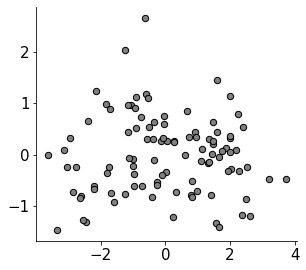

In [37]:
print(X_c.shape)
print(Y_c.shape)
print(X_t.shape)
print(a)
ax = plt.subplot(1,5,1)
plt.scatter(X_t[:, 0], X_t[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))


Automatically created module for IPython interactive environment


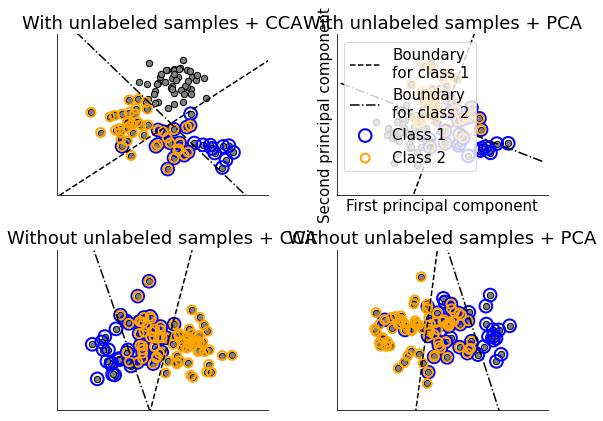

In [34]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA


def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)


def plot_subfigure(X, Y, subplot, title, transform):
    if transform == "pca":
        X = PCA(n_components=2).fit_transform(X)
    elif transform == "cca":
        X = CCA(n_components=2).fit(X, Y).transform(X)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    classif = OneVsRestClassifier(SVC(kernel='linear'))
    classif.fit(X, Y)

    plt.subplot(2, 2, subplot)
    plt.title(title)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))
    plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                facecolors='none', linewidths=2, label='Class 1')
    plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                facecolors='none', linewidths=2, label='Class 2')

    plot_hyperplane(classif.estimators_[0], min_x, max_x, 'k--',
                    'Boundary\nfor class 1')
    plot_hyperplane(classif.estimators_[1], min_x, max_x, 'k-.',
                    'Boundary\nfor class 2')
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    if subplot == 2:
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.legend(loc="upper left")


plt.figure(figsize=(8, 6))

X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=True,
                                      random_state=1)

plot_subfigure(X, Y, 1, "With unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 2, "With unlabeled samples + PCA", "pca")

X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=False,
                                      random_state=1)

plot_subfigure(X, Y, 3, "Without unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 4, "Without unlabeled samples + PCA", "pca")

plt.subplots_adjust(.04, .02, .97, .94, .09, .2)
plt.show()